In [2]:
#Importing libraries

import os                          
import glob                        
import time                       
import numpy as np                 
import pandas as pd             
import matplotlib.pyplot as plt  
import seaborn as sns           
sns.set_theme()

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    HistGradientBoostingRegressor
)
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

import xgboost as xgb                       
from IPython.display import clear_output    

In [3]:
#Importing Dataset
df_states = pd.read_csv('data/stations_info.csv')
df_states.drop(columns=['agency', 'station_location', 'start_month'], inplace=True)
df_states.head()

,file_name,state,city,start_month_num,start_year
0,AP001,Andhra Pradesh,Tirupati,7,2016
1,AP002,Andhra Pradesh,Vijayawada,5,2017
2,AP003,Andhra Pradesh,Visakhapatnam,7,2017
3,AP004,Andhra Pradesh,Rajamahendravaram,9,2017
4,AP005,Andhra Pradesh,Amaravati,11,2017


In [4]:
unique_states = df_states['state'].unique()
unique_states

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Chandigarh', 'Delhi', 'Gujarat',
       'Himachal Pradesh', 'Haryana', 'Jharkhand', 'Jammu and Kashmir',
       'Karnataka', 'Kerala', 'Maharashtra', 'Meghalaya', 'Manipur',
       'Madhya Pradesh', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab',
       'Puducherry', 'Rajasthan', 'Sikkim', 'Telangana', 'Tamil Nadu',
       'Tripura', 'Uttarakhand', 'Uttar Pradesh', 'West Bengal'],
      dtype=object)

In [5]:
#Combining all the files (from dataset) to make a single dataframe
import pandas as pd
from pathlib import Path

def combine_state_df(state_name):

    state_code = df_states.loc[df_states['state'] == state_name, 'file_name'].iloc[0][:2]
    state_files = Path('data/').glob(f'{state_code}*.csv')
    print(state_code)

    combined_df = [pd.read_csv(state_file).assign(city=df_states.loc[df_states['file_name'] == state_file.stem, 'city'].astype('string').values[0]) for state_file in state_files]
        
    return pd.concat(combined_df)


In [6]:
df = combine_state_df('Delhi')
df.info()

DL
<class 'pandas.core.frame.DataFrame'>
Index: 2796171 entries, 0 to 20841
Data columns (total 60 columns):
 #   Column               Dtype  
---  ------               -----  
 0   From Date            object 
 1   To Date              object 
 2   PM2.5 (ug/m3)        float64
 3   PM10 (ug/m3)         float64
 4   NO (ug/m3)           float64
 5   NO2 (ug/m3)          float64
 6   NOx (ppb)            float64
 7   NH3 (ug/m3)          float64
 8   SO2 (ug/m3)          float64
 9   CO (mg/m3)           float64
 10  Ozone (ug/m3)        float64
 11  Benzene (ug/m3)      float64
 12  Toluene (ug/m3)      float64
 13  Eth-Benzene (ug/m3)  float64
 14  MP-Xylene (ug/m3)    float64
 15  RH (%)               float64
 16  WS (m/s)             float64
 17  WD (degree)          float64
 18  BP (mmHg)            float64
 19  Xylene (ug/m3)       float64
 20  AT (degree C)        float64
 21  RF (mm)              float64
 22  city                 object 
 23  Temp (degree C)      float64
 24  WD

In [7]:
def create_dt_index(dataframe):
    dataframe = dataframe.drop(columns='To Date')
    dataframe['From Date'] = pd.to_datetime(dataframe['From Date'])
    dataframe = dataframe.rename(columns={'From Date': 'datetime'})
    return dataframe.set_index('datetime')

In [8]:
df = create_dt_index(df)
df.head(2)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),...,O Xylene (ug/m3),CH4 (ug/m3),NMHC (ug/m3),SPM (ug/m3),THC (ug/m3),Gust (km/hr),MP-Xylene (),Eth-Benzene (),Xylene (),CH4 ()
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-13 14:00:00,142.70,390.00,0.57,17.92,18.48,48.87,2.78,0.83,39.24,2.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-13 15:00:00,130.43,326.85,1.58,17.61,19.19,56.64,2.69,0.71,30.93,2.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Plotting similar features
def plot_similar_feature(dataframe, feature_groups, columns=2):
    rows = int((len(feature_groups)/columns)//1)
    fig, axes = plt.subplots(rows, columns, figsize=(13, 4*rows))
    fig.tight_layout(pad=3.0)
    
    row_num = 0
    col_num = 0
    for pos, group in enumerate(feature_groups):
        if pos % columns == 0 and pos != 0:
            row_num += 1
            col_num = 0
            
        for feature in feature_groups[group]:
            df_feature = dataframe[dataframe[feature].notnull()][feature]
            df_feature = df_feature.groupby([df_feature.index.year]).mean(numeric_only=True)
            sns.lineplot(data=df_feature, label=feature, ax=axes[row_num, col_num])
        axes[row_num, col_num].set_title(group)
        axes[row_num, col_num].set(xlabel=None)
        col_num += 1

    plt.plot()

/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

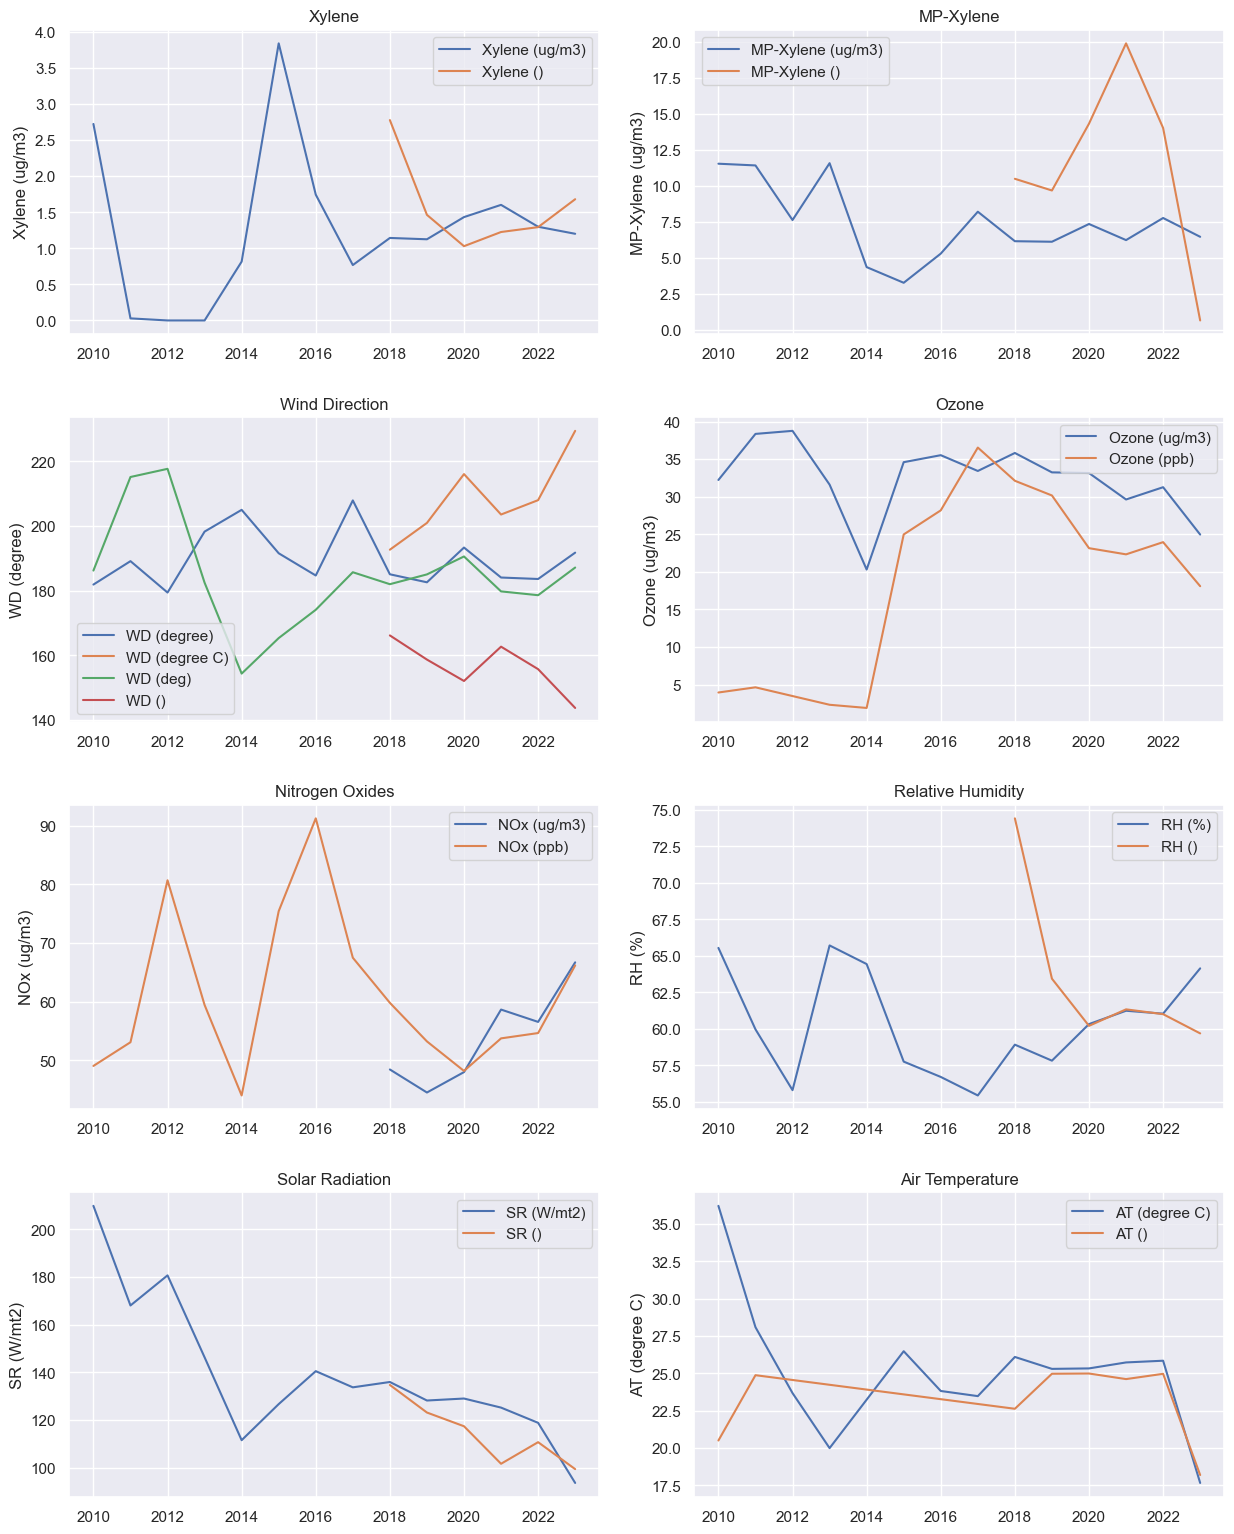

In [10]:
groups = {
    'Xylene':            ['Xylene (ug/m3)', 'Xylene ()'],
    "MP-Xylene":         ['MP-Xylene (ug/m3)', 'MP-Xylene ()'],
    'Wind Direction':    ["WD (degree)", "WD (degree C)", "WD (deg)", "WD ()"],
    'Ozone':             ['Ozone (ug/m3)', 'Ozone (ppb)'],
    'Nitrogen Oxides':   ['NOx (ug/m3)', 'NOx (ppb)'],
    'Relative Humidity': ['RH (%)', 'RH ()'],
    'Solar Radiation':   ['SR (W/mt2)', 'SR ()'],
    'Air Temperature':   ['AT (degree C)', 'AT ()']
}

plot_similar_feature(df, groups, columns=2)

In [11]:
feature_groups = {
    "Xylene (ug/m3)":    ["Xylene ()"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    "WS (m/s)":          ["WS ()"]
}

In [12]:
def merge_columns(dataframe, columns):

    for column, cols_to_merge in columns.items():
        if column not in dataframe.columns and any(col in dataframe.columns for col in cols_to_merge):
            dataframe[column] = np.nan

        for col_name in cols_to_merge:
            if col_name in dataframe.columns:
                dataframe[column] = dataframe[column].fillna(dataframe[col_name])
                dataframe = dataframe.drop(columns=[col_name])
            
    return dataframe

In [13]:
df = merge_columns(df, feature_groups)

In [14]:
df.head(1)

,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),...,HCHO (ug/m3),Hg (ug/m3),O Xylene (ug/m3),CH4 (ug/m3),NMHC (ug/m3),SPM (ug/m3),THC (ug/m3),Gust (km/hr),Eth-Benzene (),CH4 ()
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-13 14:00:00,142.7,390.0,0.57,17.92,48.87,2.78,0.83,39.24,2.4,6.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df.isnull().sum().sort_values(ascending=False)

Gust (kl/h)            2796171
Variance (n)           2796171
Eth-Benzene ()         2796171
Gust (km/hr)           2796171
SPM (ug/m3)            2796171
NMHC (ug/m3)           2796171
Temp (ug/m3)           2796171
Gust (m/s)             2796171
CO2 (mg/m3)            2796171
Power (W)              2796171
CH4 ()                 2785343
HCHO (ug/m3)           2762343
Hg (ug/m3)             2761020
MH (m)                 2758723
BP ()                  2756663
RH ()                  2756449
SR ()                  2752904
CO (ng/m3)             2752432
CH4 (ug/m3)            2734776
THC (ug/m3)            2733520
CO (ug/m3)             2712197
O Xylene (ug/m3)       2611212
Eth-Benzene (ug/m3)    2568923
Xylene (ug/m3)         2518649
MP-Xylene (ug/m3)      2502198
VWS (m/s)              2370506
Temp (degree C)        2295873
RF (mm)                1899980
AT (degree C)          1602321
BP (mmHg)              1417134
NH3 (ug/m3)            1366814
Toluene (ug/m3)        1313863
Benzene 

In [16]:
df = df.dropna(how='all')
df = df.dropna(how='all', axis='columns')

In [17]:
#Get null values
def get_null_info(dataframe):
    null_counts = df.isnull().sum()
    total_counts = len(df)
    percent_missing = (null_counts / total_counts) * 100

    null_info = pd.DataFrame({'Null Count': null_counts,
                            'Percent Missing (%)': percent_missing.round(2)})

    return null_info.sort_values(by='Null Count', ascending=False)


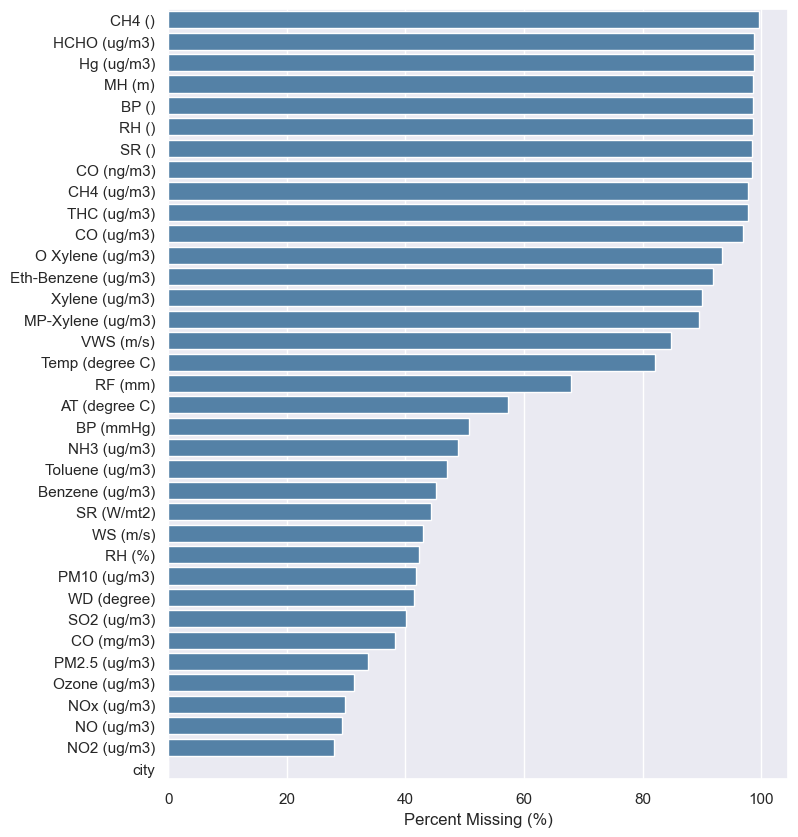

In [18]:
df_null_info = get_null_info(df)

plt.figure(figsize=(8, 10))
sns.barplot(data=df_null_info, x='Percent Missing (%)', y=df_null_info.index, orient='h', color='steelblue')
plt.show()

In [19]:
#Set a threshold of 0.6 and drop features that have null values more than that
threshold = 0.6
df = df.dropna(thresh=df.shape[0]*threshold, axis=1)

In [20]:
df.head(2)

,PM2.5 (ug/m3),NO (ug/m3),NO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),city,NOx (ug/m3)
datetime,,,,,,,
2020-11-13 14:00:00,142.70,0.57,17.92,0.83,39.24,Delhi,18.48
2020-11-13 15:00:00,130.43,1.58,17.61,0.71,30.93,Delhi,19.19


In [21]:
get_null_info(df)

,Null Count,Percent Missing (%)
CO (mg/m3),1070972,38.30
PM2.5 (ug/m3),939895,33.61
Ozone (ug/m3),873898,31.25
NOx (ug/m3),833619,29.81
NO (ug/m3),821483,29.38
NO2 (ug/m3),783452,28.02
city,0,0.00


In [22]:
pollutants = {
    'Particulate Matter' : ['PM2.5 (ug/m3)', 'PM10 (ug/m3)'],

    'Nitrogen Compounds' : ['NOx (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NH3 (ug/m3)'],

    'Hydrocarbons' : ['Benzene (ug/m3)', 'Eth-Benzene (ug/m3)', 'Xylene (ug/m3)', 'MP-Xylene (ug/m3)', 'O Xylene (ug/m3)', 'Toluene (ug/m3)'],

    'Carbon Monoxide': ['CO (mg/m3)'],

    'Sulfur Dioxide': ['SO2 (ug/m3)'],

    'Ozone Concentration' : ['Ozone (ug/m3)']
}

other_metrics = {
    'Solar Radiation' : ['SR (W/mt2)'],

    'Temperatures' : ['Temp (degree C)', 'AT (degree C)'],

    'Relative Humidity' : ['RH (%)'],

    'Rainfall' : ['RF (mm)'],

    'Barometric Pressure' : ['BP (mmHg)'],

    'Wind Direction' : ['WD (degree)'],

    'Wind Speed' : ['WS (m/s)']
}

In [23]:
slice_groups = {
    'Group by Day':   df.groupby(pd.Grouper(freq='1D')).mean(numeric_only=True),
    'Group by Month': df.groupby(pd.Grouper(freq='1M')).mean(numeric_only=True),
    'Group by Year':  df.groupby(pd.Grouper(freq='1Y')).mean(numeric_only=True)
}

In [24]:
def plot_features_by_group(features, slice_groups):    
    for feature in features:
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        fig.suptitle(feature)
        
        labels = []
        for feature_group, feature_group_df in slice_groups.items():
            feature_slice = feature_group_df[feature_group_df.columns.intersection(pollutants[feature])]
                
            feature_slice.plot(kind="line", ax=ax)
            
            for column in feature_slice.columns:
                labels.append(f'{column} [{feature_group}]')
        
        ax.set(xlabel=None)
        ax.legend(labels)
        plt.plot()

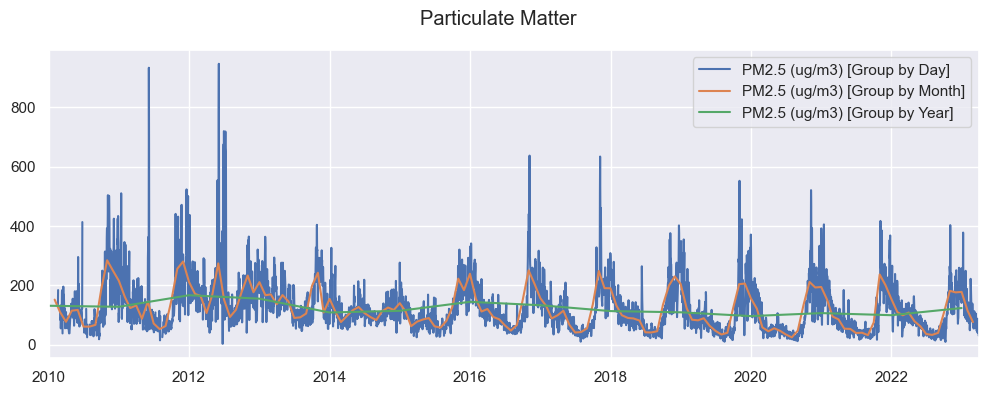

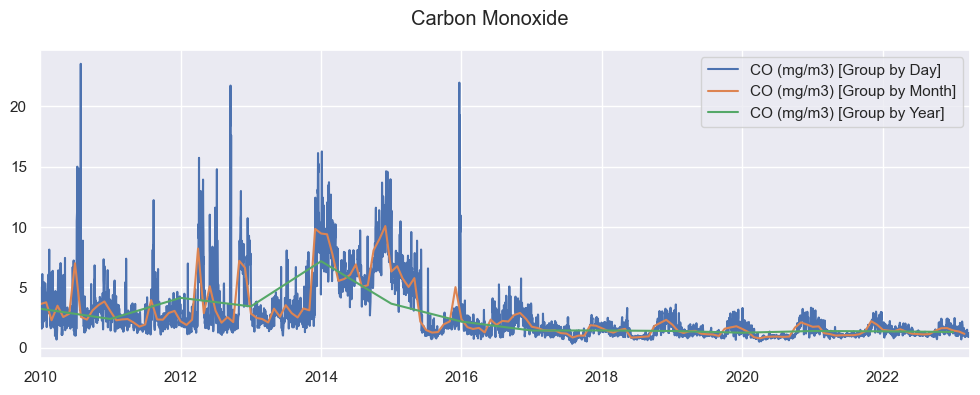

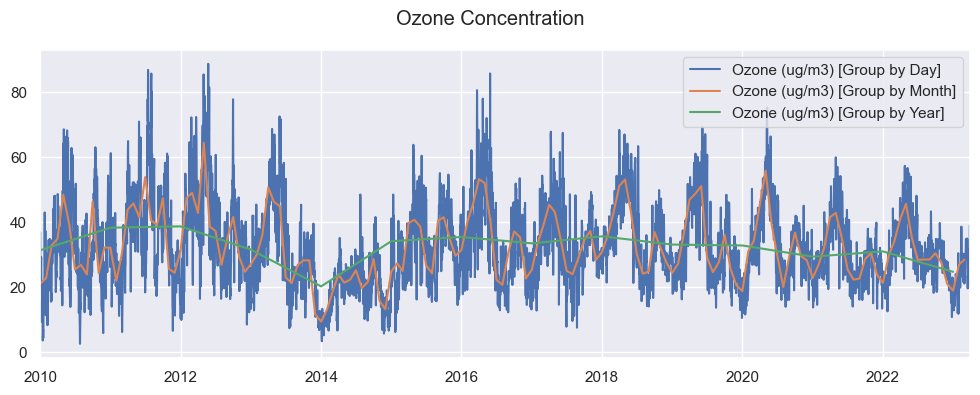

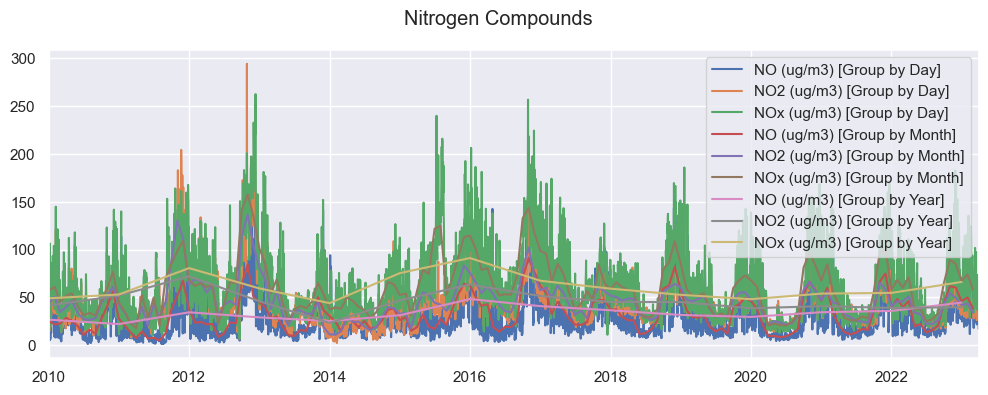

In [25]:
features_to_plot = ['Particulate Matter', 'Carbon Monoxide', 'Ozone Concentration', 'Nitrogen Compounds']
plot_features_by_group(features_to_plot, slice_groups)

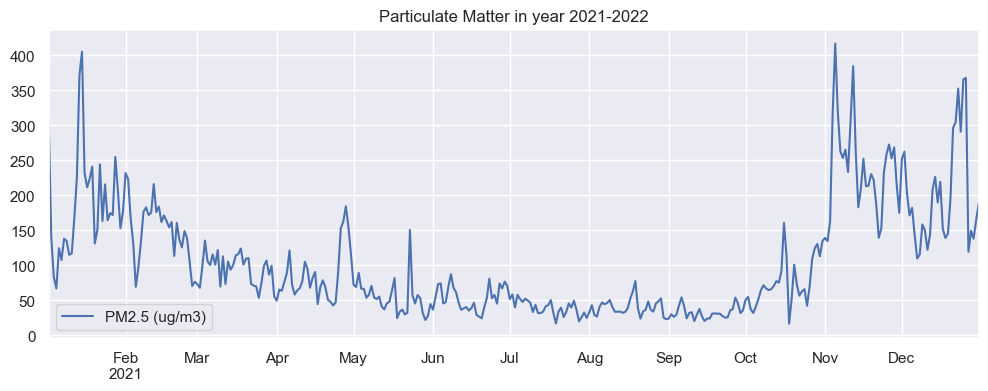

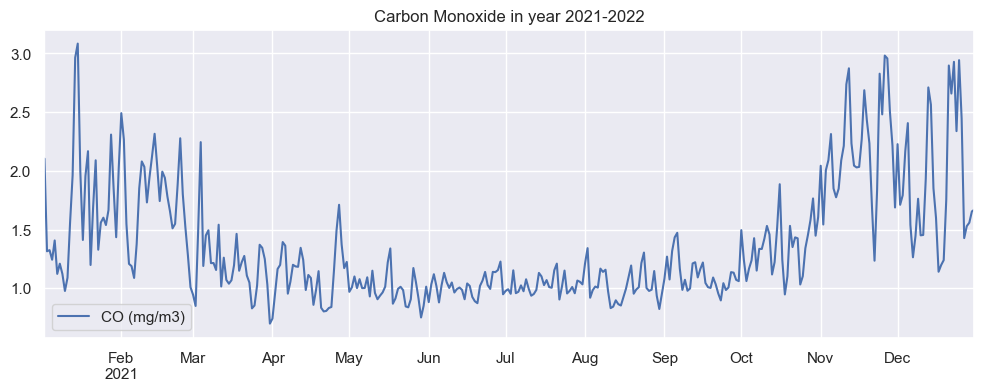

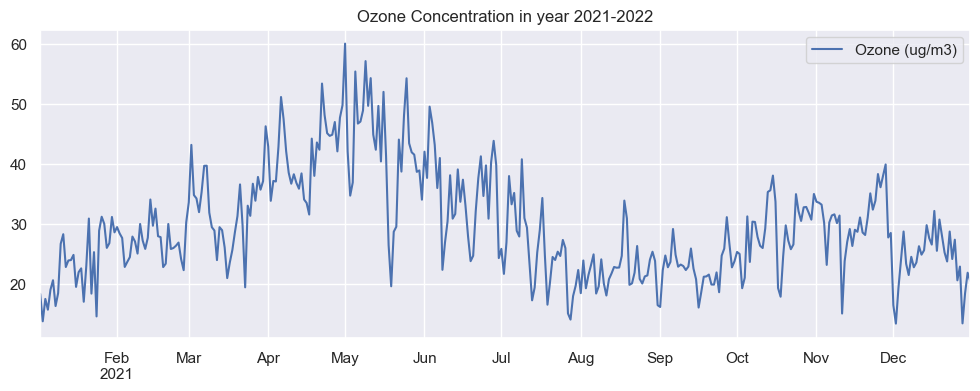

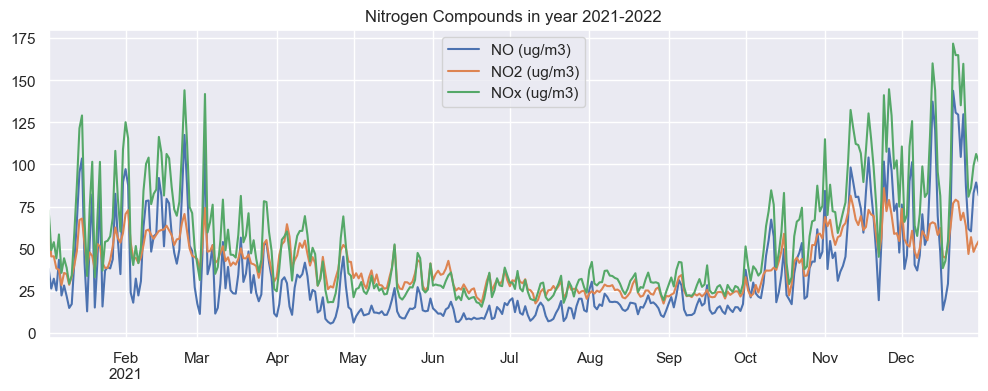

In [26]:
for feature in features_to_plot:
    data_slice = slice_groups['Group by Day'][slice_groups['Group by Day'].columns.intersection(pollutants[feature])]
    data_slice.query('datetime > 2021 and datetime < 2022').plot(title=f'{feature} in year 2021-2022', figsize=(12,4)).set(xlabel=None)

/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


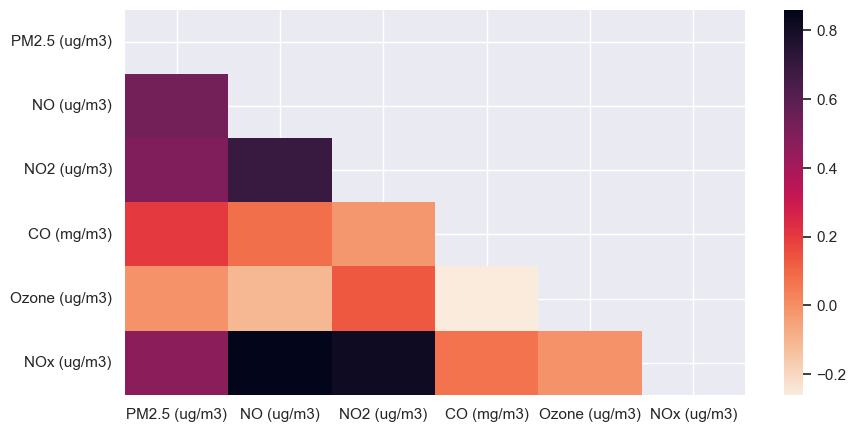

In [27]:
import numpy as np
corr = slice_groups['Group by Day'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


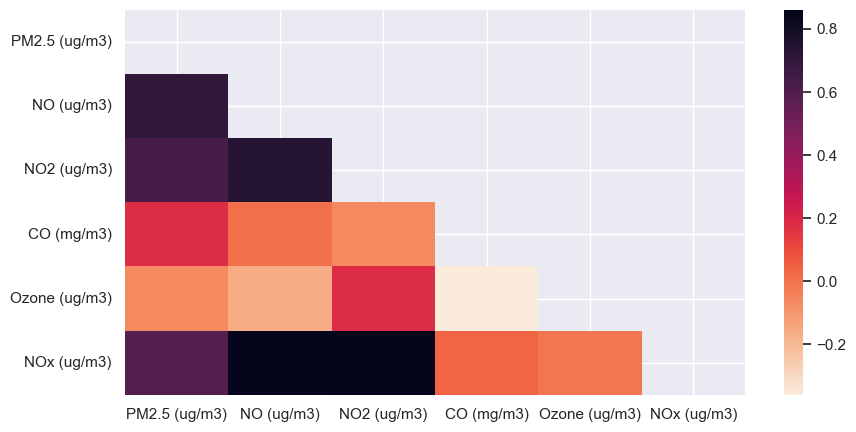

In [28]:
corr = slice_groups['Group by Month'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


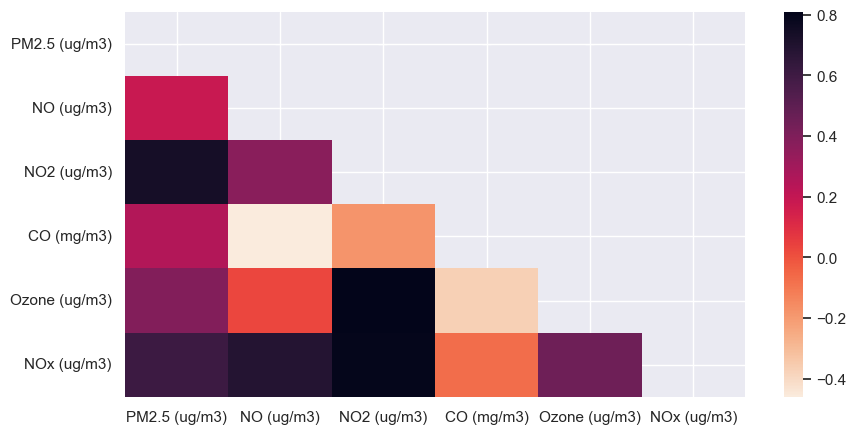

In [29]:
corr = slice_groups['Group by Year'].corr(numeric_only=True).round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10,5))
sns.heatmap(data=corr, mask=mask, annot=True, cmap="rocket_r")
plt.show()

In [30]:
corr_target = abs(corr['PM2.5 (ug/m3)'])
relevant_features = corr_target[corr_target>0.4]
relevant_features.sort_values(ascending=False)

df = df.drop(['NO (ug/m3)', 'NO2 (ug/m3)'], axis=1)
df = df.resample('60min').mean(numeric_only=True)

/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

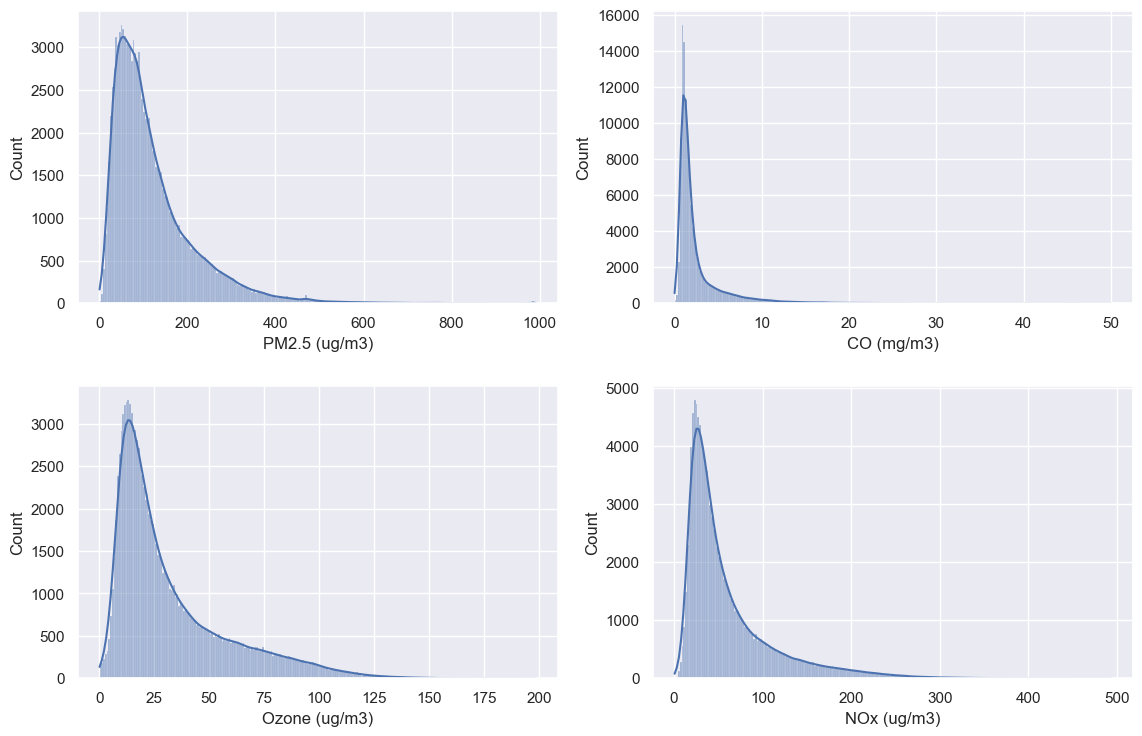

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=3.0)

sns.histplot(data=df['PM2.5 (ug/m3)'], bins=250, kde=True, ax=axes[0,0])
sns.histplot(data=df['CO (mg/m3)'], bins=250, kde=True, ax=axes[0,1])
sns.histplot(data=df['Ozone (ug/m3)'], bins=250, kde=True, ax=axes[1,0])
sns.histplot(data=df['NOx (ug/m3)'], bins=250, kde=True, ax=axes[1,1])

plt.show()

In [32]:
get_null_info(df)

,Null Count,Percent Missing (%)
PM2.5 (ug/m3),3877,3.34
CO (mg/m3),2090,1.80
Ozone (ug/m3),62,0.05
NOx (ug/m3),54,0.05


In [33]:
df = df.interpolate(method='pad')
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116112 entries, 2010-01-01 00:00:00 to 2023-03-31 23:00:00
Freq: 60T
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   PM2.5 (ug/m3)  116112 non-null  float64
 1   CO (mg/m3)     116112 non-null  float64
 2   Ozone (ug/m3)  116112 non-null  float64
 3   NOx (ug/m3)    116112 non-null  float64
dtypes: float64(4)
memory usage: 4.4 MB


/var/folders/hx/0ptq79g959sftkzv1vp9y9tm0000gn/T/ipykernel_58320/1820669235.py:1: FutureWarning: DataFrame.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='pad')


In [34]:
def create_datetime_features(df):
    df = df.copy()
    df['hour']       = df.index.hour
    df['dayofmonth'] = df.index.day
    df['dayofweek']  = df.index.dayofweek
    df['dayofyear']  = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype("int64")
    df['month']      = df.index.month
    df['quarter']    = df.index.quarter
    df['year']       = df.index.year
    return df

In [35]:
date_features = ['hour', 'dayofmonth', 'dayofweek', 'dayofyear', 'weekofyear', 'month', 'quarter', 'year']
df_xgb = create_datetime_features(df)

In [36]:
def plot_by_datetime(metric, time_groups):
    for time_group in time_groups:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(data=df_xgb, x=time_group, y=metric, palette="icefire", showfliers=False)
        ax.set_title(f'{metric} by {time_group}')
        ax.set(xlabel=time_group)
        plt.show()

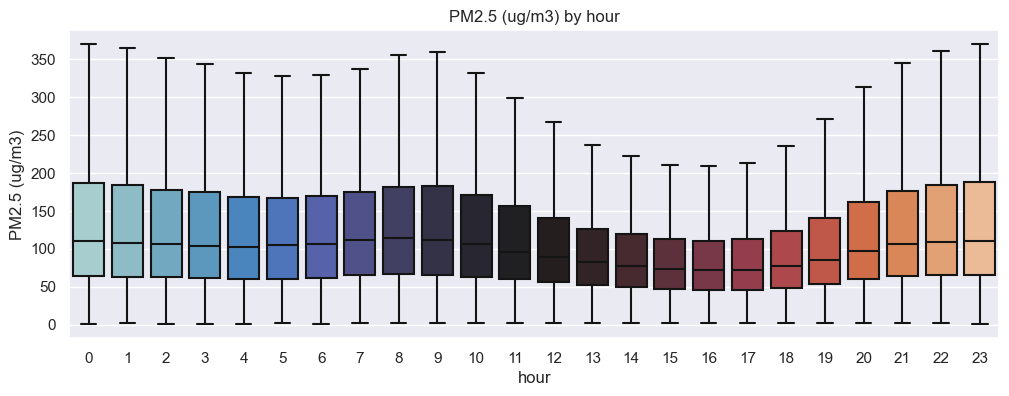

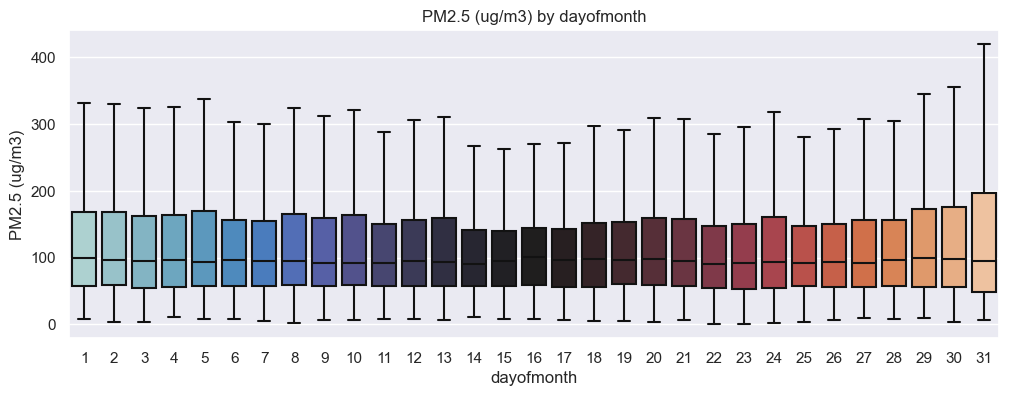

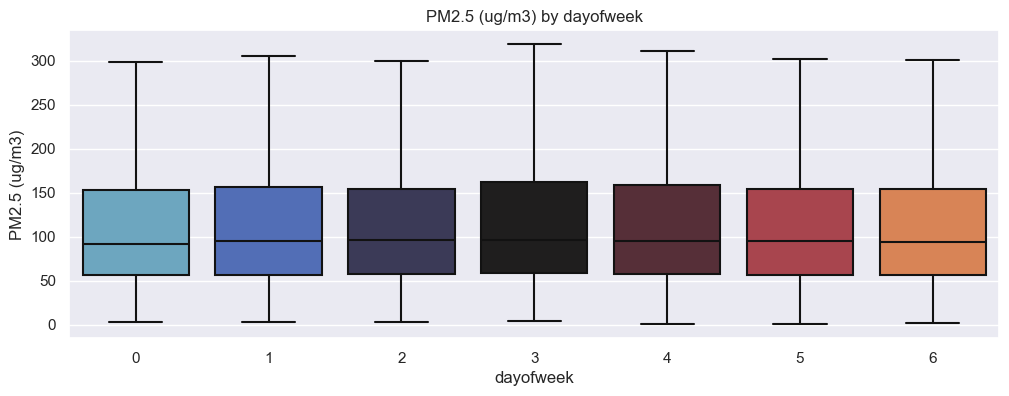

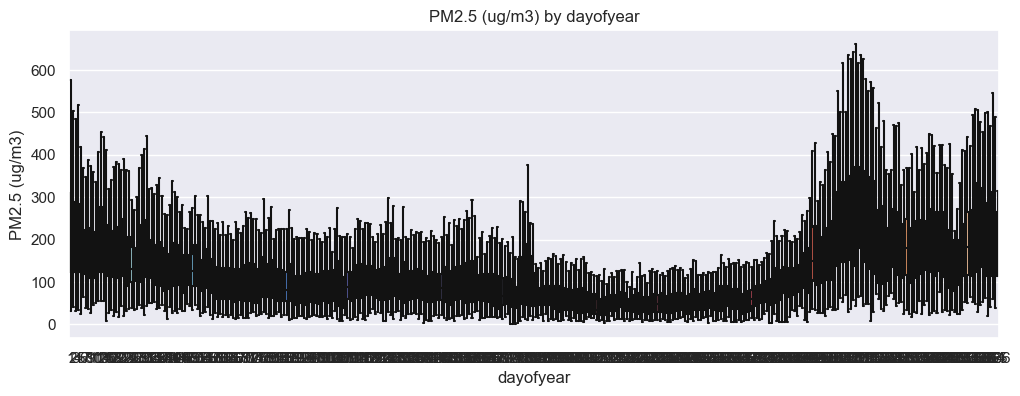

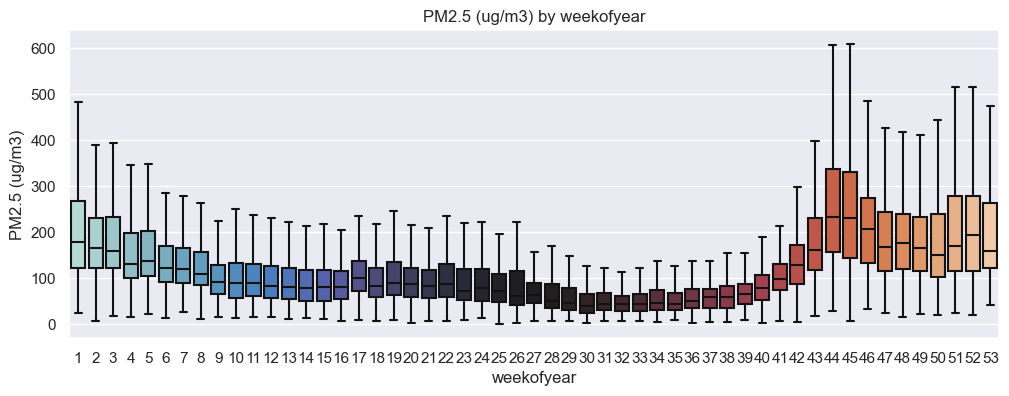

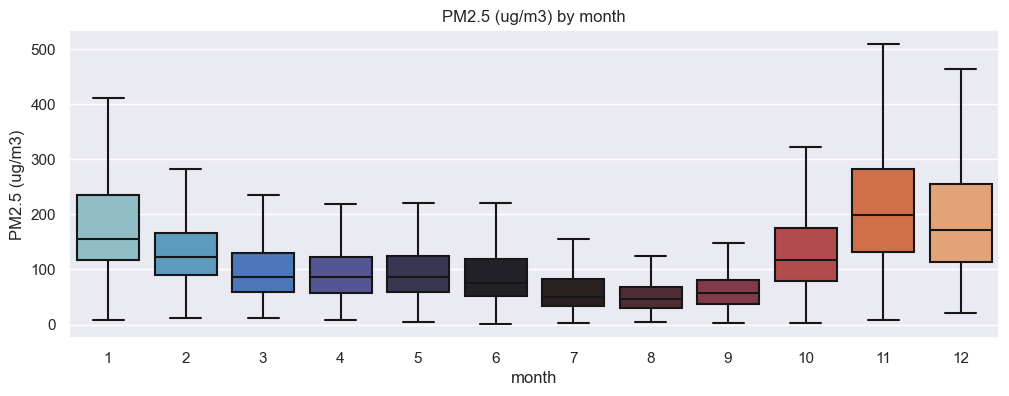

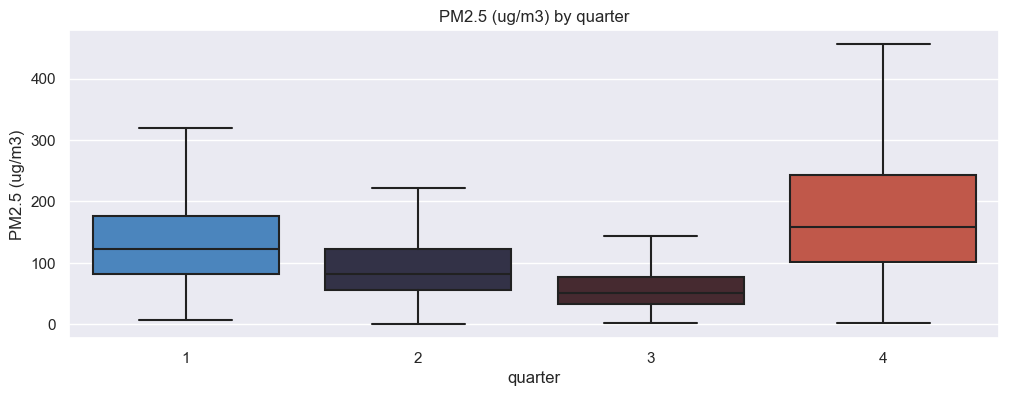

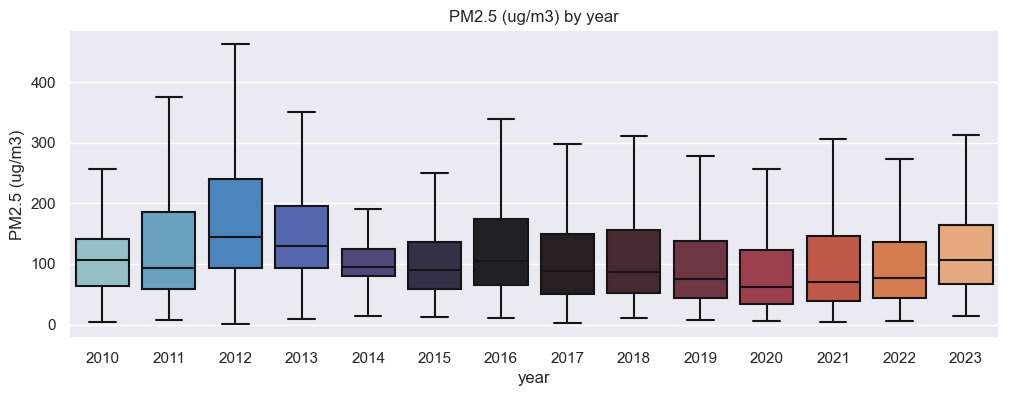

In [37]:
plot_by_datetime('PM2.5 (ug/m3)', date_features)

In [38]:
def create_lag_features(df):
    df = df.copy()
    df['lag_1Y'] = df['PM2.5 (ug/m3)'].shift(365*24)   # 1 year lag
    df['lag_2Y'] = df['PM2.5 (ug/m3)'].shift(730*24)   # 2 year lag
    return df

In [39]:
lag_features = ['lag_1Y', 'lag_2Y']
df_xgb = create_lag_features(df_xgb)
df_xgb.head()

,PM2.5 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,lag_1Y,lag_2Y
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,123.592651,2.340000,26.0650,73.7425,0,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 01:00:00,123.592651,2.327500,20.3425,36.0000,1,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 02:00:00,123.592651,2.177500,11.0650,27.1900,2,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 03:00:00,123.592651,1.992500,18.4625,21.1125,3,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 04:00:00,123.592651,2.096667,13.7500,23.1550,4,1,4,1,53,1,1,2010,NaN,NaN


In [40]:
def fill_lag_na(df, how):
    if how == 'zeros':
        return df.fillna(0)
    if how == 'drop':
        return df.dropna(how='any')

In [41]:
target = 'PM2.5 (ug/m3)'
predictors = date_features + lag_features

In [42]:
predictors

['hour',
 'dayofmonth',
 'dayofweek',
 'dayofyear',
 'weekofyear',
 'month',
 'quarter',
 'year',
 'lag_1Y',
 'lag_2Y']

In [43]:
df_xgb

,PM2.5 (ug/m3),CO (mg/m3),Ozone (ug/m3),NOx (ug/m3),hour,dayofmonth,dayofweek,dayofyear,weekofyear,month,quarter,year,lag_1Y,lag_2Y
datetime,,,,,,,,,,,,,,
2010-01-01 00:00:00,123.592651,2.340000,26.065000,73.742500,0,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 01:00:00,123.592651,2.327500,20.342500,36.000000,1,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 02:00:00,123.592651,2.177500,11.065000,27.190000,2,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 03:00:00,123.592651,1.992500,18.462500,21.112500,3,1,4,1,53,1,1,2010,NaN,NaN
2010-01-01 04:00:00,123.592651,2.096667,13.750000,23.155000,4,1,4,1,53,1,1,2010,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,30.355000,1.087714,21.778947,35.103514,19,31,4,90,13,3,1,2023,89.304211,35.435294
2023-03-31 20:00:00,32.723421,1.181714,14.617895,39.896842,20,31,4,90,13,3,1,2023,128.842432,41.377059
2023-03-31 21:00:00,44.731081,1.188235,15.136757,40.194324,21,31,4,90,13,3,1,2023,152.542895,39.174242


In [44]:
def create_train_test_sets(dataframe, split, replace_na=False, method='none'):

    dataframe = dataframe.copy()
    
    if replace_na:
        dataframe = fill_lag_na(dataframe, how=method)
        
    train_set, test_set = np.split(dataframe, [int(len(df) * split)])
    return train_set[predictors], test_set[predictors], train_set[target], test_set[target]

In [289]:
X_train, X_test, y_train, y_test = create_train_test_sets(df_xgb, split=0.8, replace_na=True, method='drop')

/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [290]:
X_train.size

928890

In [231]:
!pip install statsmodels

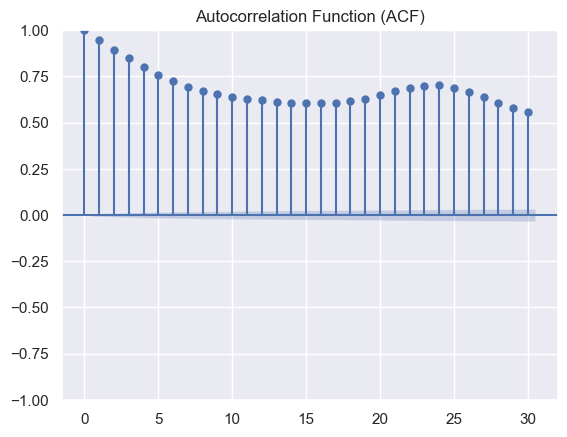

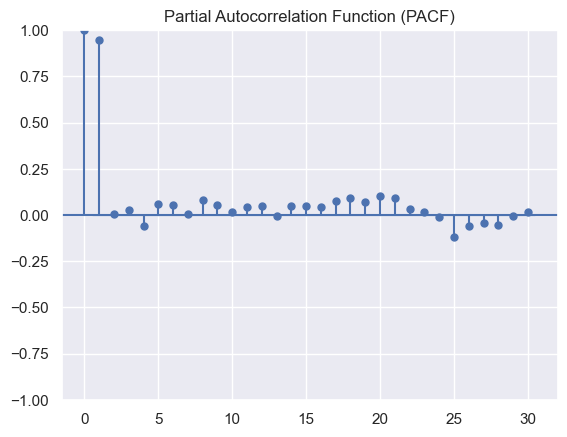

In [291]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

arima_df = X_train['lag_2Y'].values.squeeze()

plot_acf(arima_df, lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(arima_df, lags=30)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [292]:
y_train

datetime
2012-01-01 00:00:00    296.970000
2012-01-01 01:00:00    379.845000
2012-01-01 02:00:00    398.910000
2012-01-01 03:00:00    381.935000
2012-01-01 04:00:00    480.950000
                          ...    
2022-08-06 04:00:00     49.553333
2022-08-06 05:00:00     51.960571
2022-08-06 06:00:00     56.522222
2022-08-06 07:00:00     60.582778
2022-08-06 08:00:00     55.718286
Freq: 60T, Name: PM2.5 (ug/m3), Length: 92889, dtype: float64

In [293]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_xgb['PM2.5 (ug/m3)'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -14.802069739532048
p-value: 2.0921254857240025e-27
Critical Values: {'1%': -3.4304063550901662, '5%': -2.861564908104881, '10%': -2.5667832577060254}


ADF Statistics is negative, and the p-value is less than 0.05. This statistics allows us to reject the null-hypothesis stating that there exists some stationarity in the data. (d=0)

To check ‘p’, and ‘q’ parameters for the ARIMA model, ACF and PACF plots were generated. Both the ACF and PACF showed significant peaks at lag 1, therefore, the parameters passed to the ARIMA model were; ARIMA(p=1, d=0, q=1)

/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ARIMA Testing Root Mean Squared Error (RMSE): 90.01710842050933


/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


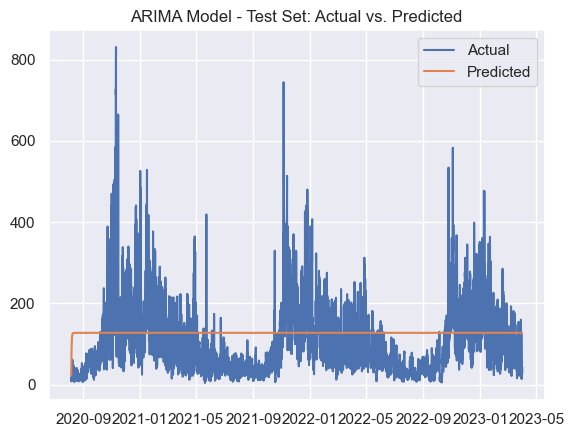

In [294]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

pm25_data = df_xgb['PM2.5 (ug/m3)']

train, test = pm25_data.iloc[:int(len(pm25_data) * 0.8)], pm25_data.iloc[int(len(pm25_data) * 0.8):]

model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

arima_rmse = mean_squared_error(test, predictions, squared=False)
print(f'ARIMA Testing Root Mean Squared Error (RMSE): {arima_rmse}')

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.legend()
plt.title('ARIMA Model - Test Set: Actual vs. Predicted')
plt.show()

/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


ARIMA Training Root Mean Squared Error (RMSE): 33.36061736787886


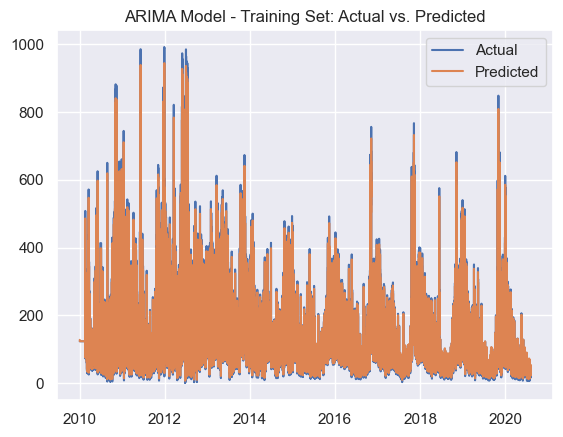

In [295]:
train_predictions = model_fit.predict(start=0, end=len(train) - 1, typ='levels')
train_rmse = mean_squared_error(train, train_predictions, squared=False)
print(f'ARIMA Training Root Mean Squared Error (RMSE): {train_rmse}')

plt.plot(train.index, train, label='Actual')
plt.plot(train.index, train_predictions, label='Predicted')
plt.legend()
plt.title('ARIMA Model - Training Set: Actual vs. Predicted')
plt.show()

In [ ]:
test

In [296]:
from xgboost import XGBRegressor 

model = XGBRegressor()
model.fit(X_train, y_train)
predictions_test = model.predict(X_test)

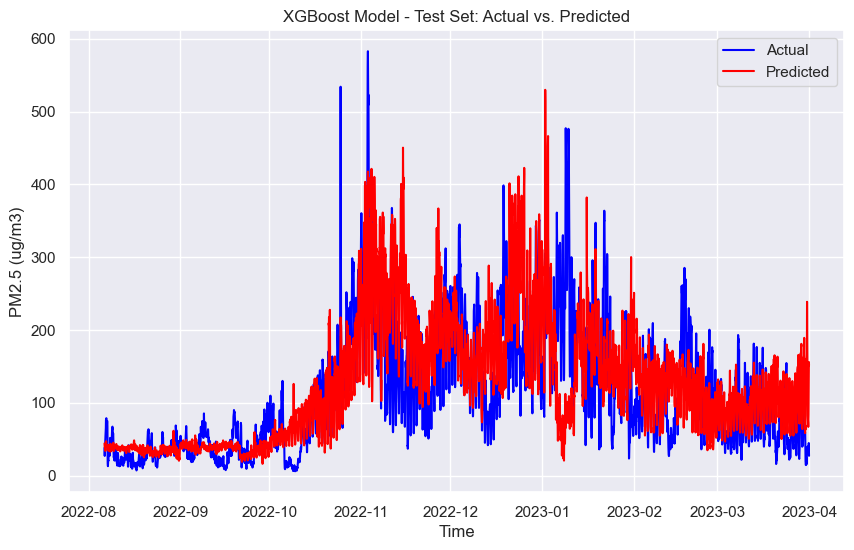

In [297]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions_test, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('PM2.5 (ug/m3)')
plt.title('XGBoost Model - Test Set: Actual vs. Predicted')
plt.legend()
plt.show()

In [298]:
from sklearn.metrics import mean_squared_error
mse_xgb_test = np.sqrt(mean_squared_error(y_test, predictions_test))
print("Test RMSE for XGBoost:", mse_xgb_test)

Test RMSE for XGBoost: 69.55611019084924


In [299]:
predictions_train = model.predict(X_train)

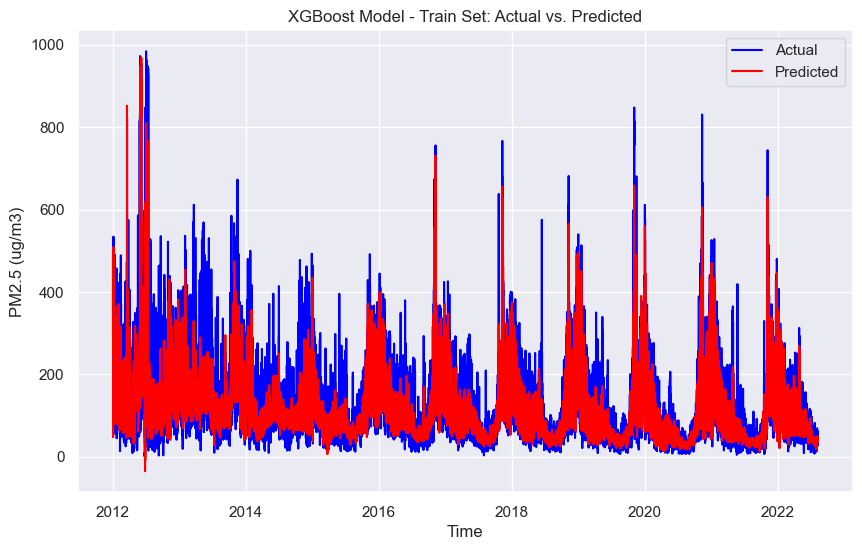

In [300]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Actual', color='blue')
plt.plot(y_train.index, predictions_train, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('PM2.5 (ug/m3)')
plt.title('XGBoost Model - Train Set: Actual vs. Predicted')
plt.legend()
plt.show()

In [301]:
from sklearn.metrics import mean_squared_error
mse_xgb_train = np.sqrt(mean_squared_error(y_train, predictions_train))
print("Train RMSE for XGBoost:", mse_xgb_train)

Train RMSE for XGBoost: 40.40433922430967


In [302]:
from sklearn.model_selection import (
    cross_val_score,
    TimeSeriesSplit,
    RandomizedSearchCV
)

N_JOBS = -1
RANDOM_STATE = 18
tscv = TimeSeriesSplit(n_splits=5) 

params = {'learning_rate': np.arange(0.01,1,0.01),
                'n_estimators': [20,50,100,250],
                'max_depth': [None,3,5],
                'eval_metric': ['rmse'],
                'early_stopping_rounds': [10],
                'n_jobs': [N_JOBS],
                'random_state': [RANDOM_STATE]}

rscv_model = RandomizedSearchCV(model, params,
                                        cv=tscv,
                                        scoring="neg_root_mean_squared_error",
                                        return_train_score=True,
                                        n_jobs=-1,
                                        n_iter=20,
                                        random_state=18)

In [303]:
rscv_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)    
model_xgb_rscv = rscv_model.best_estimator_
model_scores = round(-rscv_model.best_score_, 4)

print(model_xgb_rscv, model_scores)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.24, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=18, ...) 70.0829


In [304]:
model_xgb_cv = model_xgb_rscv.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)
predictions_test_xgb_cv = model_xgb_cv.predict(X_test)

In [305]:
predictions_test_xgb_cv

array([ 50.964054,  50.964054,  45.973576, ..., 106.38039 , 106.38039 ,
       106.38039 ], dtype=float32)

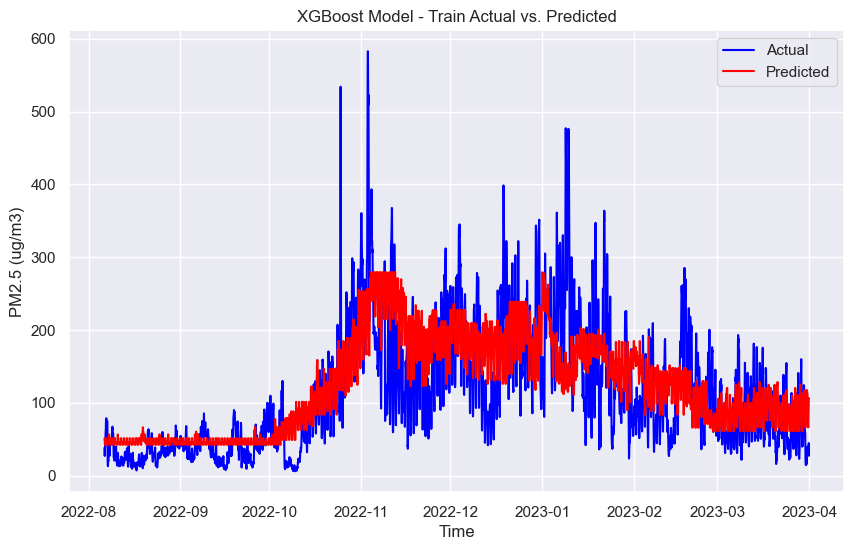

In [306]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions_test_xgb_cv, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('PM2.5 (ug/m3)')
plt.title('XGBoost Model - Train Actual vs. Predicted')
plt.legend()
plt.show()

In [307]:
rmse_xgb_cv = np.sqrt(mean_squared_error(y_test, predictions_test_xgb_cv))
print("RMSE after hyperparameter tuning:", rmse_xgb_cv)

RMSE after hyperparameter tuning: 58.8620335200012


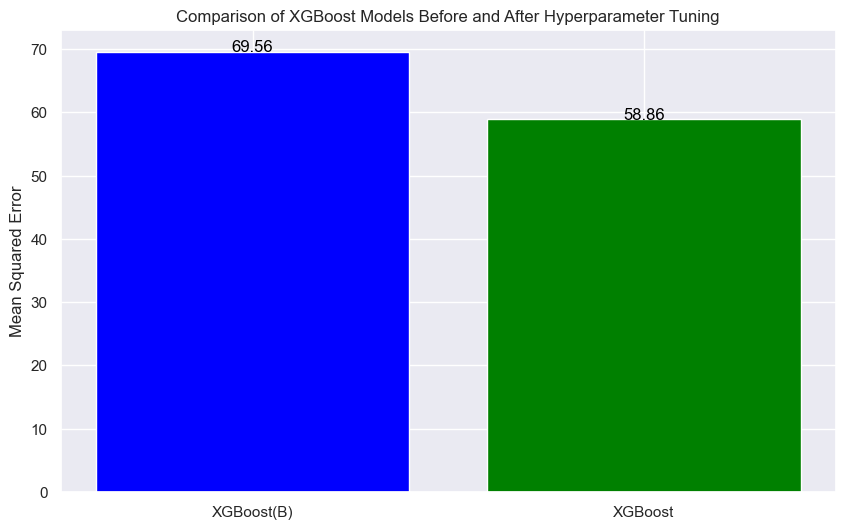

In [308]:
rmse_scores = [mse_xgb_test, rmse_xgb_cv]

plt.figure(figsize=(10, 6))
plt.bar(['XGBoost(B)', 'XGBoost'], rmse_scores, color=['blue', 'green'])

for x, y in zip(['XGBoost(B)', 'XGBoost'], rmse_scores):
    plt.text(x, y + 0.01, f'{y:.2f}', ha='center', color='black')

plt.title('Comparison of XGBoost Models Before and After Hyperparameter Tuning')
plt.ylabel('Mean Squared Error')
plt.show()

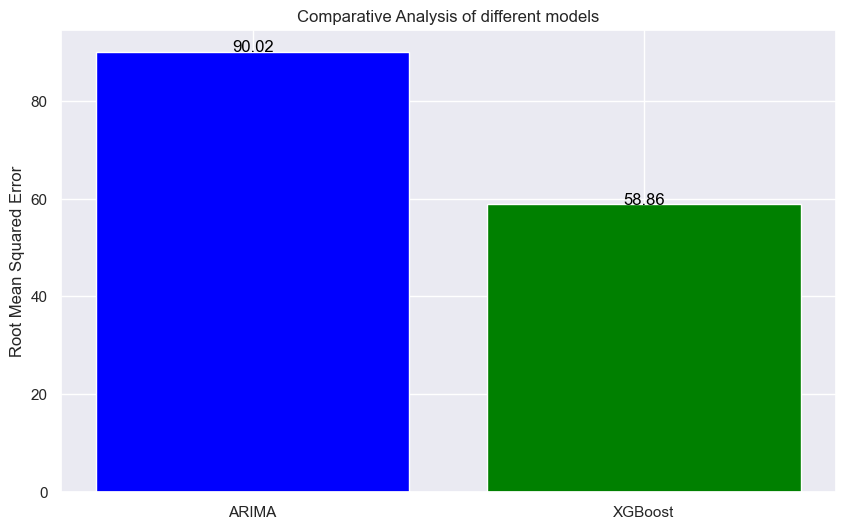

In [309]:
rmse_scores = [arima_rmse, rmse_xgb_cv
              ]

plt.figure(figsize=(10, 6))
plt.bar(['ARIMA', 'XGBoost'], rmse_scores, color=['blue', 'green'])

for x, y in zip(['ARIMA', 'XGBoost'], rmse_scores):
    plt.text(x, y + 0.01, f'{y:.2f}', ha='center', color='black')

plt.title('Comparative Analysis of different models')
plt.ylabel('Root Mean Squared Error')
plt.show()

In [310]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_df = pd.DataFrame(scaler.fit_transform(df_xgb), columns=df_xgb.columns)

In [311]:
X_train, X_test, y_train, y_test = create_train_test_sets(normalized_df, split=0.8, replace_na=True, method='drop')
X_train_array = X_train.values
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)
X_train = X_train_reshaped

/Users/harshalgeete/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [332]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
from keras.optimizers import Adam

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50 ))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mean_squared_error')

In [333]:
model.fit(X_train, y_train, epochs = 20, batch_size = 32)

Epoch 1/20
2903/2903 [==============================] - 16s 5ms/step - loss: 0.7293
Epoch 2/20
2903/2903 [==============================] - 14s 5ms/step - loss: 0.6766
Epoch 3/20
2903/2903 [==============================] - 14s 5ms/step - loss: 0.6538
Epoch 4/20
2903/2903 [==============================] - 16s 5ms/step - loss: 0.6279
Epoch 5/20
2903/2903 [==============================] - 13s 5ms/step - loss: 0.6060
Epoch 6/20
2903/2903 [==============================] - 13s 5ms/step - loss: 0.5914
Epoch 7/20
2903/2903 [==============================] - 14s 5ms/step - loss: 0.5855
Epoch 8/20
2903/2903 [==============================] - 14s 5ms/step - loss: 0.5795
Epoch 9/20
2903/2903 [==============================] - 13s 5ms/step - loss: 0.5741
Epoch 10/20
2903/2903 [==============================] - 13s 5ms/step - loss: 0.5689
Epoch 11/20
2903/2903 [==============================] - 13s 4ms/step - loss: 0.5656
Epoch 12/20
2903/2903 [==============================] - 13s 4ms/step - lo

In [334]:
y_pred = model.predict(X_test)

179/179 [==============================] - 1s 1ms/step


In [337]:
from sklearn.metrics import mean_squared_error
lstm_mse = np.sqrt(mean_squared_error(y_test, y_pred))

In [338]:
lstm_mse

0.6137378827834655

In [339]:
y_train_pred = model.predict(X_train)

2903/2903 [==============================] - 4s 1ms/step


In [340]:
lstm_train_mse = np.sqrt(mean_squared_error(y_train, y_train_pred))

In [341]:
lstm_train_mse

0.7138716125772957

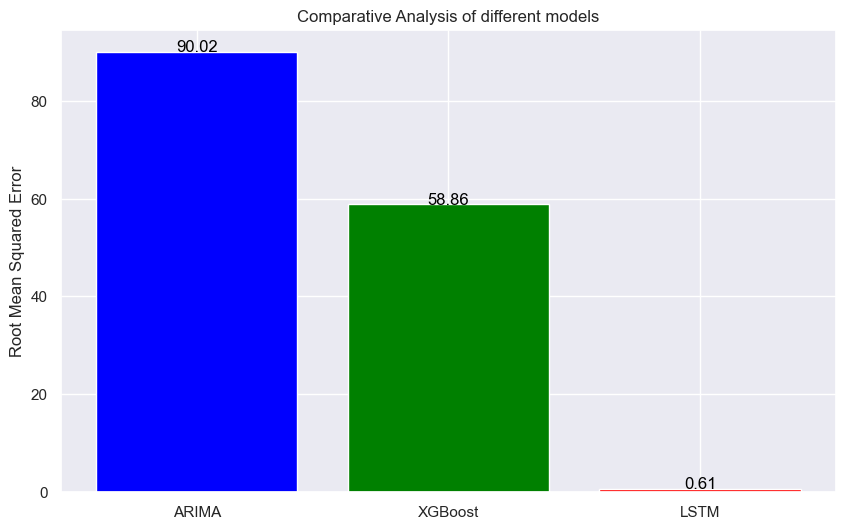

In [342]:
rmse_scores = [arima_rmse, rmse_xgb_cv, lstm_mse]

plt.figure(figsize=(10, 6))
plt.bar(['ARIMA', 'XGBoost', 'LSTM'], rmse_scores, color=['blue', 'green', 'red'])

for x, y in zip(['ARIMA', 'XGBoost', 'LSTM'], rmse_scores):
    plt.text(x, y + 0.01, f'{y:.2f}', ha='center', color='black')

plt.title('Comparative Analysis of different models')
plt.ylabel('Root Mean Squared Error')
plt.show()

In [343]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 10, 50)            10400     
                                                                 
 dropout_63 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_65 (LSTM)              (None, 10, 50)            20200     
                                                                 
 dropout_64 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_66 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_65 (Dropout)        (None, 50)                0         
                                                                 
 dense_19 (Dense)            (None, 1)               